### Loading the libraries

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.base import clone

In [241]:
# reading the data
data = pd.read_csv('D:\data\census.csv')

data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Data Exploration

In [242]:
dictionary = {}
for i in data.columns:
    dictionary[i] = Counter(data[i])

dictionary.update(dictionary.fromkeys(['age','education-num','capital-gain','capital-loss','hours-per-week'], 'continuous'))
dictionary

{'age': 'continuous',
 'workclass': Counter({' State-gov': 1946,
          ' Self-emp-not-inc': 3796,
          ' Private': 33307,
          ' Federal-gov': 1406,
          ' Local-gov': 3100,
          ' Self-emp-inc': 1646,
          ' Without-pay': 21}),
 'education_level': Counter({' Bachelors': 7570,
          ' HS-grad': 14783,
          ' 11th': 1619,
          ' Masters': 2514,
          ' 9th': 676,
          ' Some-college': 9899,
          ' Assoc-acdm': 1507,
          ' 7th-8th': 823,
          ' Doctorate': 544,
          ' Assoc-voc': 1959,
          ' Prof-school': 785,
          ' 5th-6th': 449,
          ' 10th': 1223,
          ' Preschool': 72,
          ' 12th': 577,
          ' 1st-4th': 222}),
 'education-num': 'continuous',
 'marital-status': Counter({' Never-married': 14598,
          ' Married-civ-spouse': 21055,
          ' Divorced': 6297,
          ' Married-spouse-absent': 552,
          ' Separated': 1411,
          ' Married-AF-spouse': 32,
          ' W

In [243]:
# number of records
print("no of rows: ",data.shape[0])
print("no of columns: ",data.shape[1])

# no of individuals making more than 50K
response = Counter(data['income'])
print("Individuals earning greater than 50K: ",response['>50K'])
print("Individuals earning less than 50K: ", response['<=50K'])
print("percent making more than 50K: ", round((response['>50K']*100)/data.shape[0],2),"%")

no of rows:  45222
no of columns:  14
Individuals earning greater than 50K:  11208
Individuals earning less than 50K:  34014
percent making more than 50K:  24.78 %


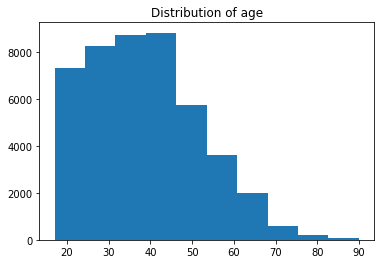

In [244]:
plt.hist(data['age'])
plt.title('Distribution of age')
plt.show()

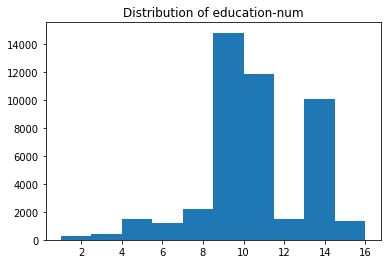

In [245]:
plt.hist(data['education-num'])
plt.title('Distribution of education-num')
plt.show()

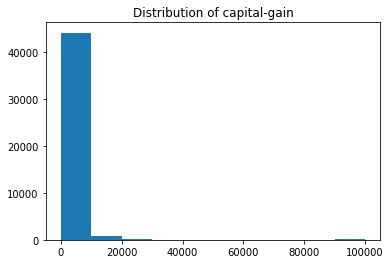

In [246]:
plt.hist(data['capital-gain'])
plt.title('Distribution of capital-gain')
plt.show()

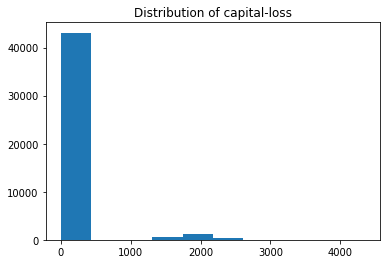

In [247]:
plt.hist(data['capital-loss'])
plt.title('Distribution of capital-loss')
plt.show()

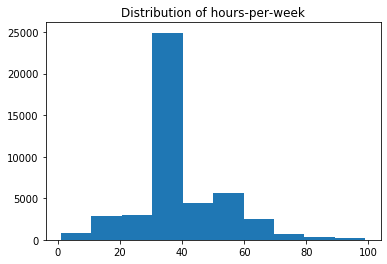

In [248]:
plt.hist(data['hours-per-week'])
plt.title('Distribution of hours-per-week')
plt.show()

### Preparing the data

Transforming skewed continuous features

In [249]:
target = data['income']
features = data.drop('income',axis=1)

In [250]:
skewed = ['capital-gain','capital-loss']
log_features = pd.DataFrame(data=features)
log_features[skewed] = log_features[skewed].apply(lambda x: np.log(x+1))

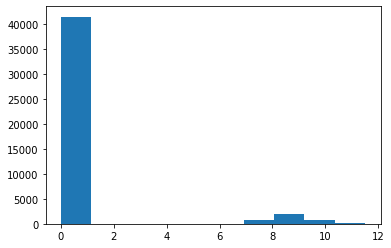

In [251]:
plt.hist(log_features['capital-gain'])
plt.show()

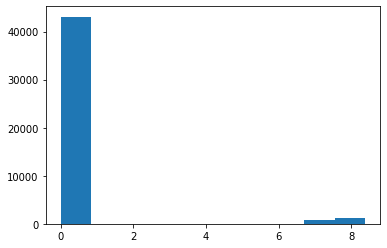

In [252]:
plt.hist(log_features['capital-loss'])
plt.show()

Scaling all the numerical features

In [253]:
scaler = MinMaxScaler()
numerical = ['age','education-num','capital-gain','capital-loss','hours-per-week']

log_scaled_features = pd.DataFrame(data=log_features)
log_scaled_features[numerical] = scaler.fit_transform(log_scaled_features[numerical]) 

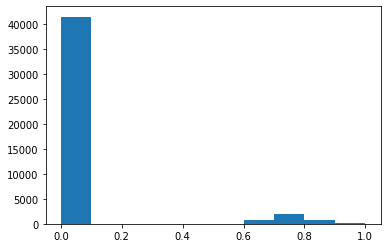

In [254]:
plt.hist(log_scaled_features['capital-gain'])
plt.show()

In [255]:
features_final = pd.get_dummies(log_scaled_features) # dropfirst not done
target = target.map({'<=50K':0, '>50K':1})

encoded = list(features_final.columns)
print("{} total features after encoding".format(len(encoded)))


103 total features after encoding


In [256]:
x_train,x_test,y_train,y_test= train_test_split(features_final,target, test_size=0.3, random_state=2) #cv not used

print("The training set has {} rows".format(x_train.shape[0]))
print('The test set has {} rows'.format(x_test.shape[0]))

The training set has 31655 rows
The test set has 13567 rows


### Naive Predictor Performance

In [257]:
#Assuming the model predicts all the individuals as earning more than 50k 

TP = np.sum(target)
FP = target.count() - TP

FN = 0
TN = 0

b = 0.5

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)

fscore_05 = (1+(b**2)) * ((precision * recall)/(((b**2) * precision) + recall))

print("Naive score: accuracy {:0.4f}, fscore_05 {:0.4f}".format(accuracy, fscore_05))

Naive score: accuracy 0.2478, fscore_05 0.2917


#### Naive Bayes

industrial use 
    - document classification
strengths 
    - it is a fast algorithm
    - it also performs well with multi class outputs
weekness
    - Assumes zero when a new category appears in the test data which was not found in the training data
    - The probabiliity are assumed to be not very reliable
This model can be used as the data has all the values in numerical format, the output is a classification 


#### Decision trees

industrial use
    - growth opportunities
    - marketing new channels
strengths
    - easy to read and interpret
    - less sensitive to outliers and missing values
weekness
    - unstable nature, such that a small change in the data can give different results. Bagging and boosting can help
    - Loss of information when categorizing continuous output.
This can work well with classification problem and it gives a clear idea on who might end up donating

#### Adaboosting

industrial use
    - Customer churn
strengths
    - imporves the accuracy of weak classifiers
    - easier to use with less hyperparameter tweaking
weekness
    - highly sensitive to outliers and noisy data
Since using a decision tree, using adaboost might give a better prediction with the classification problem and give better results

### Training and predicting pipeline

In [258]:
def train_predict(learner, sample_size, x_train, x_test, y_train, y_test):
    """
    input:
    learner: the ML algorithm to use
    sample_size: No of samples to use from the training set
    x_train: training features
    x_test: testing features
    y_train: training target
    y_test: testing target
    
    output:
    results: 
    """
    
    results = {}
    
    start = time()
    learner.fit(x_train[:sample_size], y_train[:sample_size])
    end = time()
    
    results['train time'] = end - start
    
    start = time()
    predict_test = learner.predict(x_test)
    predict_train = learner.predict(x_train[:300])
    end = time()
    
    results['pred_time'] = end-start
    
    results['acc_train'] = accuracy_score(y_train[:300],predict_train)
    
    results['acc_test'] = accuracy_score(y_test,predict_test)
    
    results['f_05_train'] = fbeta_score(y_train[:300], predict_train, beta=0.5)
    
    results['f_05_test'] = fbeta_score(y_test, predict_test, beta=0.5)
    
    print("{} trained on {} samples".format(learner.__class__.__name__, sample_size))
    
    return results
    
    
    

### Initial Model Evaluation

In [259]:
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state = 2)
clf_C = AdaBoostClassifier(random_state = 3)

sample_100 = int(len(y_train))
sample_10 = int(len(y_train)*0.10)
sample_1 = int(len(y_train)*0.01)

results = {}

for i in [clf_A, clf_B, clf_C]:
    clf_name = i.__class__.__name__
    results[clf_name] = {}
    for j,samples in enumerate([sample_1, sample_10, sample_100]):
        results[clf_name][j] = \
        train_predict(i, samples, x_train, x_test, y_train, y_test)

GaussianNB trained on 316 samples
GaussianNB trained on 3165 samples
GaussianNB trained on 31655 samples
DecisionTreeClassifier trained on 316 samples
DecisionTreeClassifier trained on 3165 samples
DecisionTreeClassifier trained on 31655 samples
AdaBoostClassifier trained on 316 samples
AdaBoostClassifier trained on 3165 samples
AdaBoostClassifier trained on 31655 samples


In [260]:
dictionary ={}
for i in results.keys():
    for j in results[i].keys():
        dictionary[(i,j)] = results[i][j]

In [261]:
results_df = pd.DataFrame(dictionary)

In [262]:
results_df

GaussianNB                     DecisionTreeClassifier            \
                    0         1         2                      0         1   
train time   0.008018  0.007997  0.087960               0.007998  0.039999   
pred_time    0.039969  0.032011  0.056000               0.016000  0.008030   
acc_train    0.503333  0.366667  0.563333               1.000000  0.993333   
acc_test     0.444461  0.344881  0.598437               0.788531  0.804010   
f_05_train   0.398587  0.341991  0.411204               1.000000  0.994832   
f_05_test    0.344874  0.316037  0.425059               0.571556  0.605820   

                     AdaBoostClassifier                      
                   2                  0         1         2  
train time  0.311997           0.064000  0.295995  2.255972  
pred_time   0.008003           0.343998  0.335998  0.256001  
acc_train   0.980000           0.923333  0.863333  0.863333  
acc_test    0.813518           0.825238  0.846318  0.852141  
f_05_train  0.968992           0.866667  0.758017  0.761194  
f_05_test   0.625538           0.651139  0.702574  0.719237

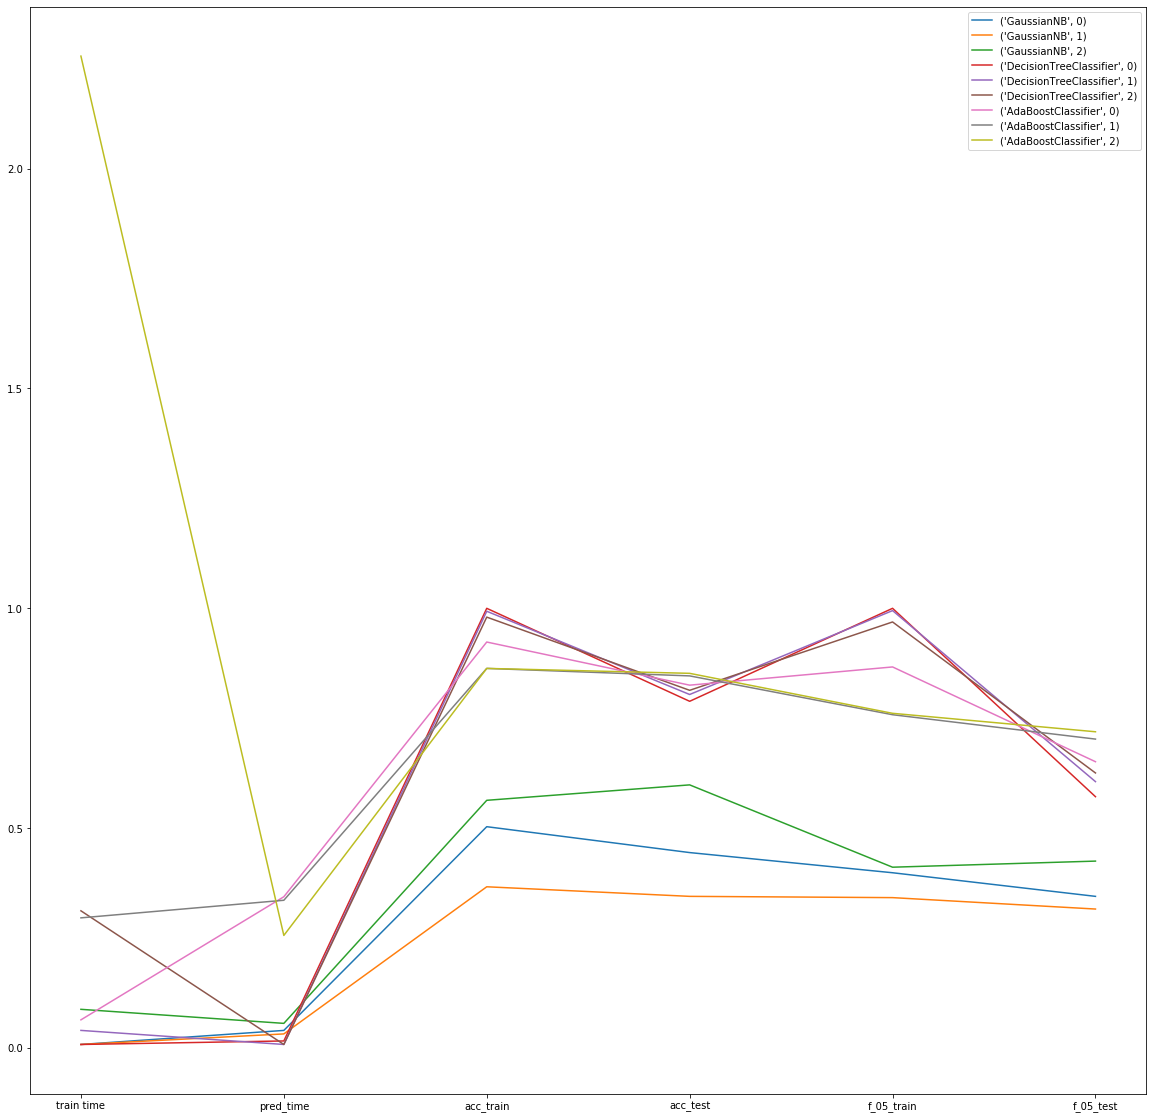

In [263]:
plt.figure(figsize=(20,20))
plt.plot(results_df)
plt.legend(results_df.columns)
plt.show()

### Choosing the best model

Looking at the graph we see a lot of difference in the parameters
Looking at the f score for the test set for all the algorithms we have the AdaBoost for the entire data set performing the best with an f score of 0.719. 

With prediction time we have decision trees with 10% of the training data with the lowest time 0f 0.006982.
The training time of gaussian naive bayes is the lowest with 0.006981 with the 10% training data.

All the three algorithms choosen are a good fit for this classification model, of which the AdaBoosting even though it takes time to train the data, gives the highest accuracy.

### Describing the model in layman's terms

adaboost is a machine learning technique which works on the fundametals of decision trees and random forests. It basically performs better as it uses a summation of multiple decision trees. It bascially punishes wrong predictions more than correct predictions which forces the model to perform better.

### Model Tuning

In [264]:
clf = AdaBoostClassifier(random_state = 3)

parameters = {'n_estimators':[100,150],'learning_rate':[0.8,0.4]}

scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring = scorer)

grid_fit = grid_obj.fit(x_train, y_train)

best_clf = grid_fit.best_estimator_

predict_unoptimized = clf.fit(x_train,y_train).predict(x_test)
best_predict = best_clf.predict(x_test)

print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predict_unoptimized)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predict_unoptimized, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predict)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predict, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8521
F-score on testing data: 0.7192

Optimized Model
------
Final accuracy score on the testing data: 0.8567
Final F-score on the testing data: 0.7300


### Final Model Evaluation 

In [265]:
dictionary = {'Accuracy score':[0.8521,0.8567],'F-score':[0.7192,0.7300]}

final_eval = pd.DataFrame(dictionary, index=['Unoptimized','Optimized'])
final_eval

,Accuracy score,F-score
Unoptimized,0.8521,0.7192
Optimized,0.8567,0.7300


### Feature importance

In [266]:
importance = clf.feature_importances_
column_names = features_final.columns
important_features ={}
for i in range(len(column_names)):
    important_features[column_names[i]] = importance[i]

important_features = dict(sorted(important_features.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(15,15))
plt.bar(list(important_features.keys())[0:20], list(important_features.values())[0:20])


IndexError: index 15 is out of bounds for axis 0 with size 15

### Feature Selection

In [ ]:
x_train_reduced = x_train[list(important_features.keys())[0:15]]
x_test_reduced = x_test[list(important_features.keys())[0:15]]

clf = clone(best_clf).fit(x_train_reduced,y_train)
reduced_predict = clf.predict(x_test_reduced)

print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predict)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predict, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predict)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predict, beta = 0.5)))